<a href="https://www.kaggle.com/code/sahartriki/projet-ia-avanc?scriptVersionId=156493701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [34]:
#visualisation
import pathlib
import matplotlib.pyplot as plt
import PIL
#numpy / pandas / os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 
#train_test_split
from sklearn.model_selection import  train_test_split
import shutil
#tensorflow + keras 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
from pathlib import Path
input_folder = Path('../input/v2-plant-seedlings-dataset')
output_folder = './dataset'

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders 
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2)) 


In [ ]:
import os

def print_folder_structure(root_folder, excluded_extensions=('png',)):
    for root, dirs, files in os.walk(root_folder):
        level = root.replace(root_folder, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for file in files:
            if not any(file.lower().endswith(ext) for ext in excluded_extensions):
                print('{}{}'.format(subindent, file))

root_folder = '/kaggle/working/'
excluded_extensions = ('png',)
print_folder_structure(root_folder, excluded_extensions)


In [ ]:
import glob

def print_dataset_lengths(train_length, test_length):
    print(f"Train Length: {train_length}")
    print(f"Test Length: {test_length}")

# the paths to train and test folders
train_folder = '/kaggle/working/dataset/train'
test_folder = '/kaggle/working/dataset/test'

# Calculate the lengths of train and test datasets
train_length = sum(len(glob.glob(f'{train_folder}/*/*.png')) for name in glob.glob(train_folder))
test_length = sum(len(glob.glob(f'{test_folder}/*/*.png')) for name in glob.glob(test_folder))

# Print the lengths
print_dataset_lengths(train_length, test_length)

In [ ]:
batch_size = 32
img_height = 120
img_width = 120

In [ ]:
data_dir_train = '/kaggle/working/dataset/train'
data_dir_test = '/kaggle/working/dataset/test'

In [ ]:
# creating train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='training', seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size )


In [ ]:
# creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                            image_size=(img_height, img_width), batch_size=batch_size)

In [ ]:
import os
import shutil

folders = ['train', 'test', 'val']

for folder in folders:
    folder_path = f'/kaggle/working/dataset/{folder}/nonsegmentedv2'

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"{folder_path} has been deleted.")
    else:
        print(f"{folder_path} does not exist.")

## Data visualisation

In [ ]:
# Listing out all the classes of plant seedlings and store them in a list.
labels = sorted(os.listdir(data_dir_train))
print(labels)


In [ ]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [ ]:
count_plot

In [ ]:
percentages = count_plot / np.sum(count_plot) * 100
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Plant Seeding Classes')
plt.show()

**Remarque** : Unbalanced Data


In [ ]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(labels[label[i]])
        plt.axis("off")

# Models

## Model 1 CNN  : 
    
* 12 classes present in the dataset .
* Rescaling to normalize pixel values between (0,1) because   the RGB channel values are in the [0,255] range .
* Height and Width (120, 120): 
The height and width represent the spatial dimensions of the image.
the  choose  of dimensions : when the image is  small enough it  allows for faster model training while still retaining enough details for accurate classification .
* Channels (3):
The third dimension (3) represents the number of color channels in the image.
this value is set to 3, indicating the Red, Green, and Blue (RGB) color channels.
   
   



 * this code defines the beginning of a convolutional neural network for image classification. The Rescaling layer normalizes the pixel values, and the Conv2D layer with a ReLU activation starts to capture hierarchical features from the input images.**

In [ ]:
input_shape = (120,120,3)
num_classes = 12

# creating layers for the first model using conv2D
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
# using batch normalization
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling  model 1

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

### Model 1 Training

In [ ]:
epochs = 20
batch_size = 64
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  Evaluate model 1

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f'Validation Loss: {test_loss}')
print(f'Validation Accuracy: {test_accuracy}')

## Model 2 ( modéle avancé )  :

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'  # This ensures one-hot encoding of the labels
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'  # This ensures one-hot encoding of the labels
)

In [ ]:
# GLOBAL VARIABLES
scale = 70
seed = 7

In [ ]:
input_shape = (120, 120, 3)
num_classes = 12

model2 = Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(32, (3, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(128, (3, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(128, (3, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(256, (3, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(256, (3, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Flatten the output for Dense layers
model2.add(layers.Flatten())

# Dense layers
model2.add(layers.Dense(512))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Activation('relu'))

model2.add(layers.Dense(256))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Activation('relu'))

model2.add(layers.Dense(num_classes, activation='softmax'))

# Display model summary
model2.summary()


In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
epochs = 20
batch_size = 32

# Fit the model using the training dataset and specifying the validation dataset
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model2.evaluate(val_ds)
print(f'Validation Loss: {test_loss}')
print(f'Validation Accuracy: {test_accuracy*100} %')

## Model 3 : 

### Data Augmentation : 

In [ ]:
image_dir = Path('../input/v2-plant-seedlings-dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffling the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# result
image_df.head(3)

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Load the pretained model MobileNet 
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images = create_gen()

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:

history = model3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
result = model3.evaluate(test_images, verbose=0)

In [ ]:
print("Test Loss: {:.5f}".format(result[0]))
print("Accuracy on the test set: {:.2f}%".format(result[1] * 100))

In [ ]:
# Predict the label of the test_images
pred = model3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
lab = (train_images.class_indices)
lab = dict((v,k) for k,v in lab.items())
pred = [lab[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test is your true labels and pred is your predicted labels
y_test = list(test_df.Label)
report = classification_report(y_test, pred, zero_division=1)

print(report)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Model 4 :  

**Segmentation**

In [35]:
import cv2
from os import listdir
import os
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [36]:
Directory='../input/v2-plant-seedlings-dataset/nonsegmentedv2/'
subfolders = listdir(Directory)
print(os.listdir('../input/v2-plant-seedlings-dataset/nonsegmentedv2/'))

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherd’s Purse']


**2.1 Import the images**

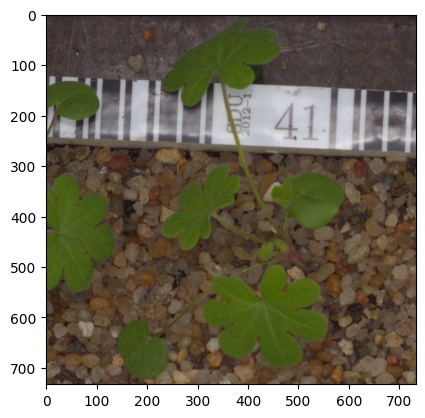

In [37]:
p1 = cv2.imread('/kaggle/input/v2-plant-seedlings-dataset/nonsegmentedv2/Small-flowered Cranesbill/135.png')
p1 = cv2.cvtColor(p1, cv2.COLOR_BGR2RGB)
plt.imshow(p1)
plt.grid(False)
plt.show()

In [38]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

**Visualize the plant image in RGB color space:**

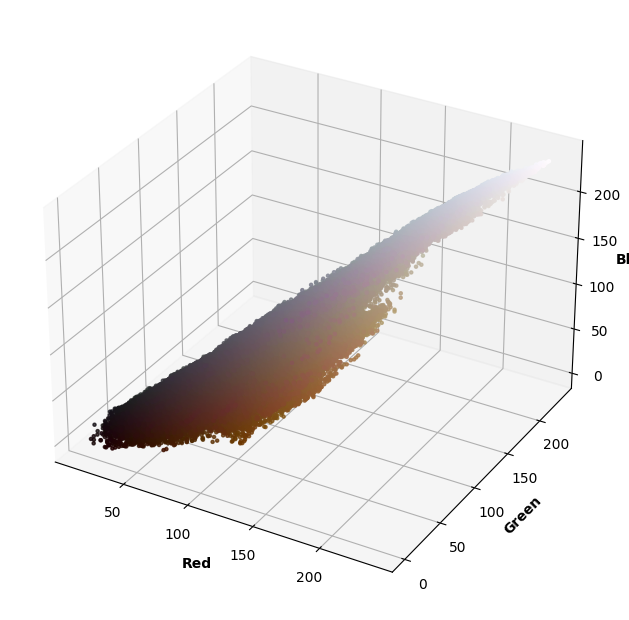

In [39]:
r, g, b = cv2.split(p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
set_size(6,6)
pixel_colors = p1.reshape((np.shape(p1)[0]*np.shape(p1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red", weight='bold')
axis.set_ylabel("Green", weight='bold')
axis.set_zlabel("Blue", weight='bold')

plt.show()

In [40]:
hsv_p1 = cv2.cvtColor(p1, cv2.COLOR_RGB2HSV)

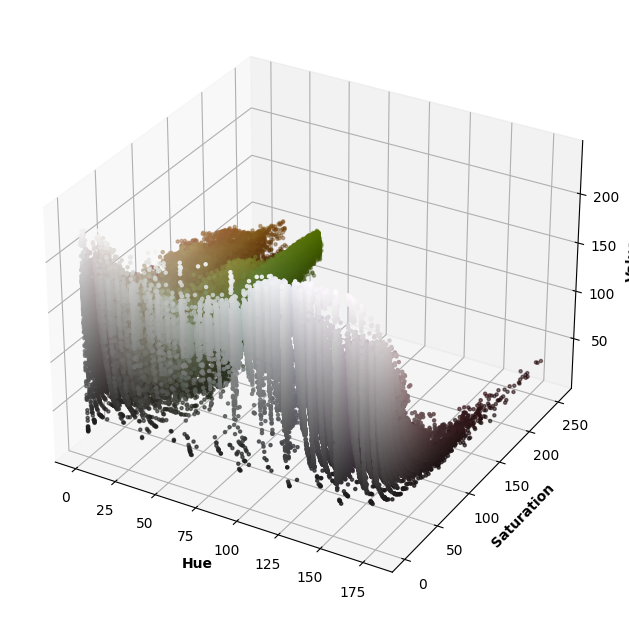

In [41]:
h, s, v = cv2.split(hsv_p1)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")


axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue",weight='bold')
axis.set_ylabel("Saturation", weight='bold')
axis.set_zlabel("Value", weight='bold')
set_size(6,6)
plt.show()

- **Color Space:** The analysis is performed in the HSV (Hue, Saturation, Value) color space.
  
- **Localization of Greens:** Plant greens in the image are more concentrated and visually distinguishable in the HSV color space.

- **Hue Axis Significance:** The hue axis is crucial, as the saturation and value of the greens exhibit variations but predominantly fall within a narrow range along the hue axis.

- **Segmentation Leverage:** The limited range of saturation and value along the hue axis is a key feature that can be utilized for effective segmentation of the plant's greens in the image.

### Segmentation part : Color-based segmentation:

In [42]:
def plot_mask(image, colormin, colormax):
        hsv_p1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)   
        mask = cv2.inRange(hsv_p1, colormin , colormax)
        result = cv2.bitwise_and(image, image, mask=mask)
        plt.figure(figsize=(15,10))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.grid(False)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.grid(False)
        plt.subplot(1, 3, 3)
        plt.imshow(result)
        plt.grid(False)
        return plt.show()

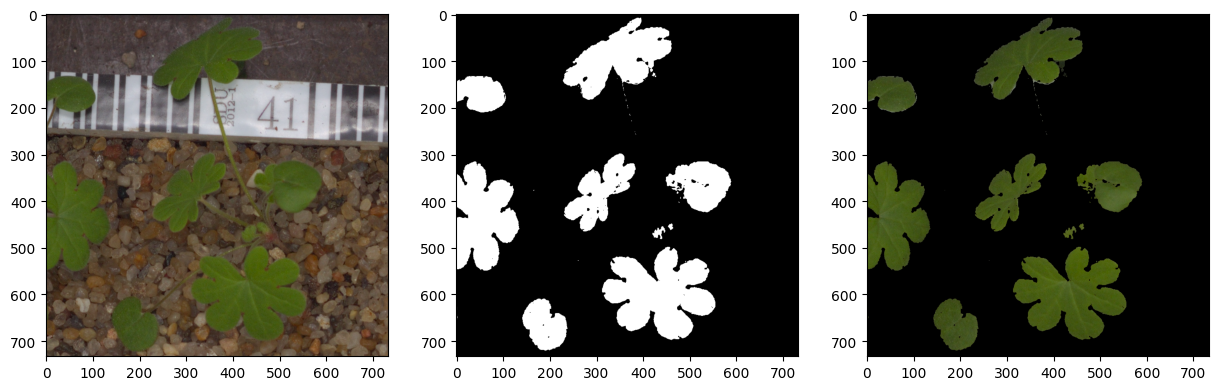

In [43]:
colormin=(36, 25, 25)
colormax=(70, 255,255)

plot_mask(p1, colormin, colormax)

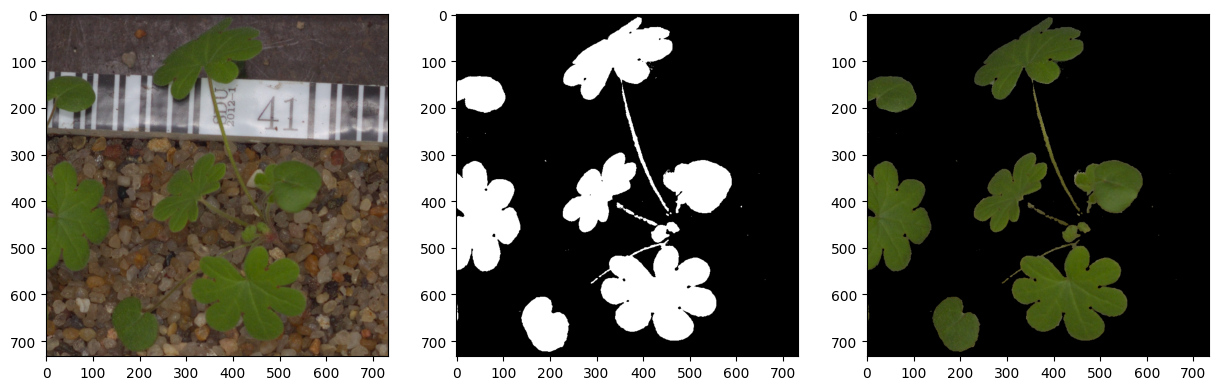

In [44]:
new_colormin=(25,50,50)
new_colormax=(80,255,255)
plot_mask(p1, new_colormin, new_colormax)

In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # Import Image module from PIL

def segmented(image, image_path):
    foto = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_foto = cv2.cvtColor(foto, cv2.COLOR_RGB2HSV)
    
    colormin = (25, 50, 50)
    colormax = (86, 255, 255)

    mask = cv2.inRange(hsv_foto, colormin, colormax)
    result = cv2.bitwise_and(foto, foto, mask=mask)
    pil_image = Image.fromarray(result)

    # Save the segmented image in the working directory
    save_path = f"/kaggle/working/segmented_{os.path.basename(image_path)}"
    pil_image.save(save_path)
    print(f"Segmented image saved to: {save_path}")

    return result

In [46]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Path to the folder containing segmented images
segmented_images_folder = "/kaggle/working/"

# Load segmented images and corresponding labels
data = []
labels = []

for n in range(12):
    folder = subfolders[n]
    files = listdir(Directory + folder + "/")
    
    for file in files:
        image_path = Directory + folder + "/" + file
        image = cv2.imread(image_path)
        segmented_image = segmented(image, image_path)
        
        # Resize the segmented image to the desired input size for MobileNetV2
        segmented_image = cv2.resize(segmented_image, (224, 224))
        
        data.append(segmented_image)
        labels.append(folder)

Segmented image saved to: /kaggle/working/segmented_173.png
Segmented image saved to: /kaggle/working/segmented_491.png
Segmented image saved to: /kaggle/working/segmented_379.png
Segmented image saved to: /kaggle/working/segmented_248.png
Segmented image saved to: /kaggle/working/segmented_94.png
Segmented image saved to: /kaggle/working/segmented_480.png
Segmented image saved to: /kaggle/working/segmented_236.png
Segmented image saved to: /kaggle/working/segmented_340.png
Segmented image saved to: /kaggle/working/segmented_48.png
Segmented image saved to: /kaggle/working/segmented_513.png
Segmented image saved to: /kaggle/working/segmented_350.png
Segmented image saved to: /kaggle/working/segmented_314.png
Segmented image saved to: /kaggle/working/segmented_227.png
Segmented image saved to: /kaggle/working/segmented_238.png
Segmented image saved to: /kaggle/working/segmented_61.png
Segmented image saved to: /kaggle/working/segmented_377.png
Segmented image saved to: /kaggle/working/s

In [47]:
# Convert the lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42)

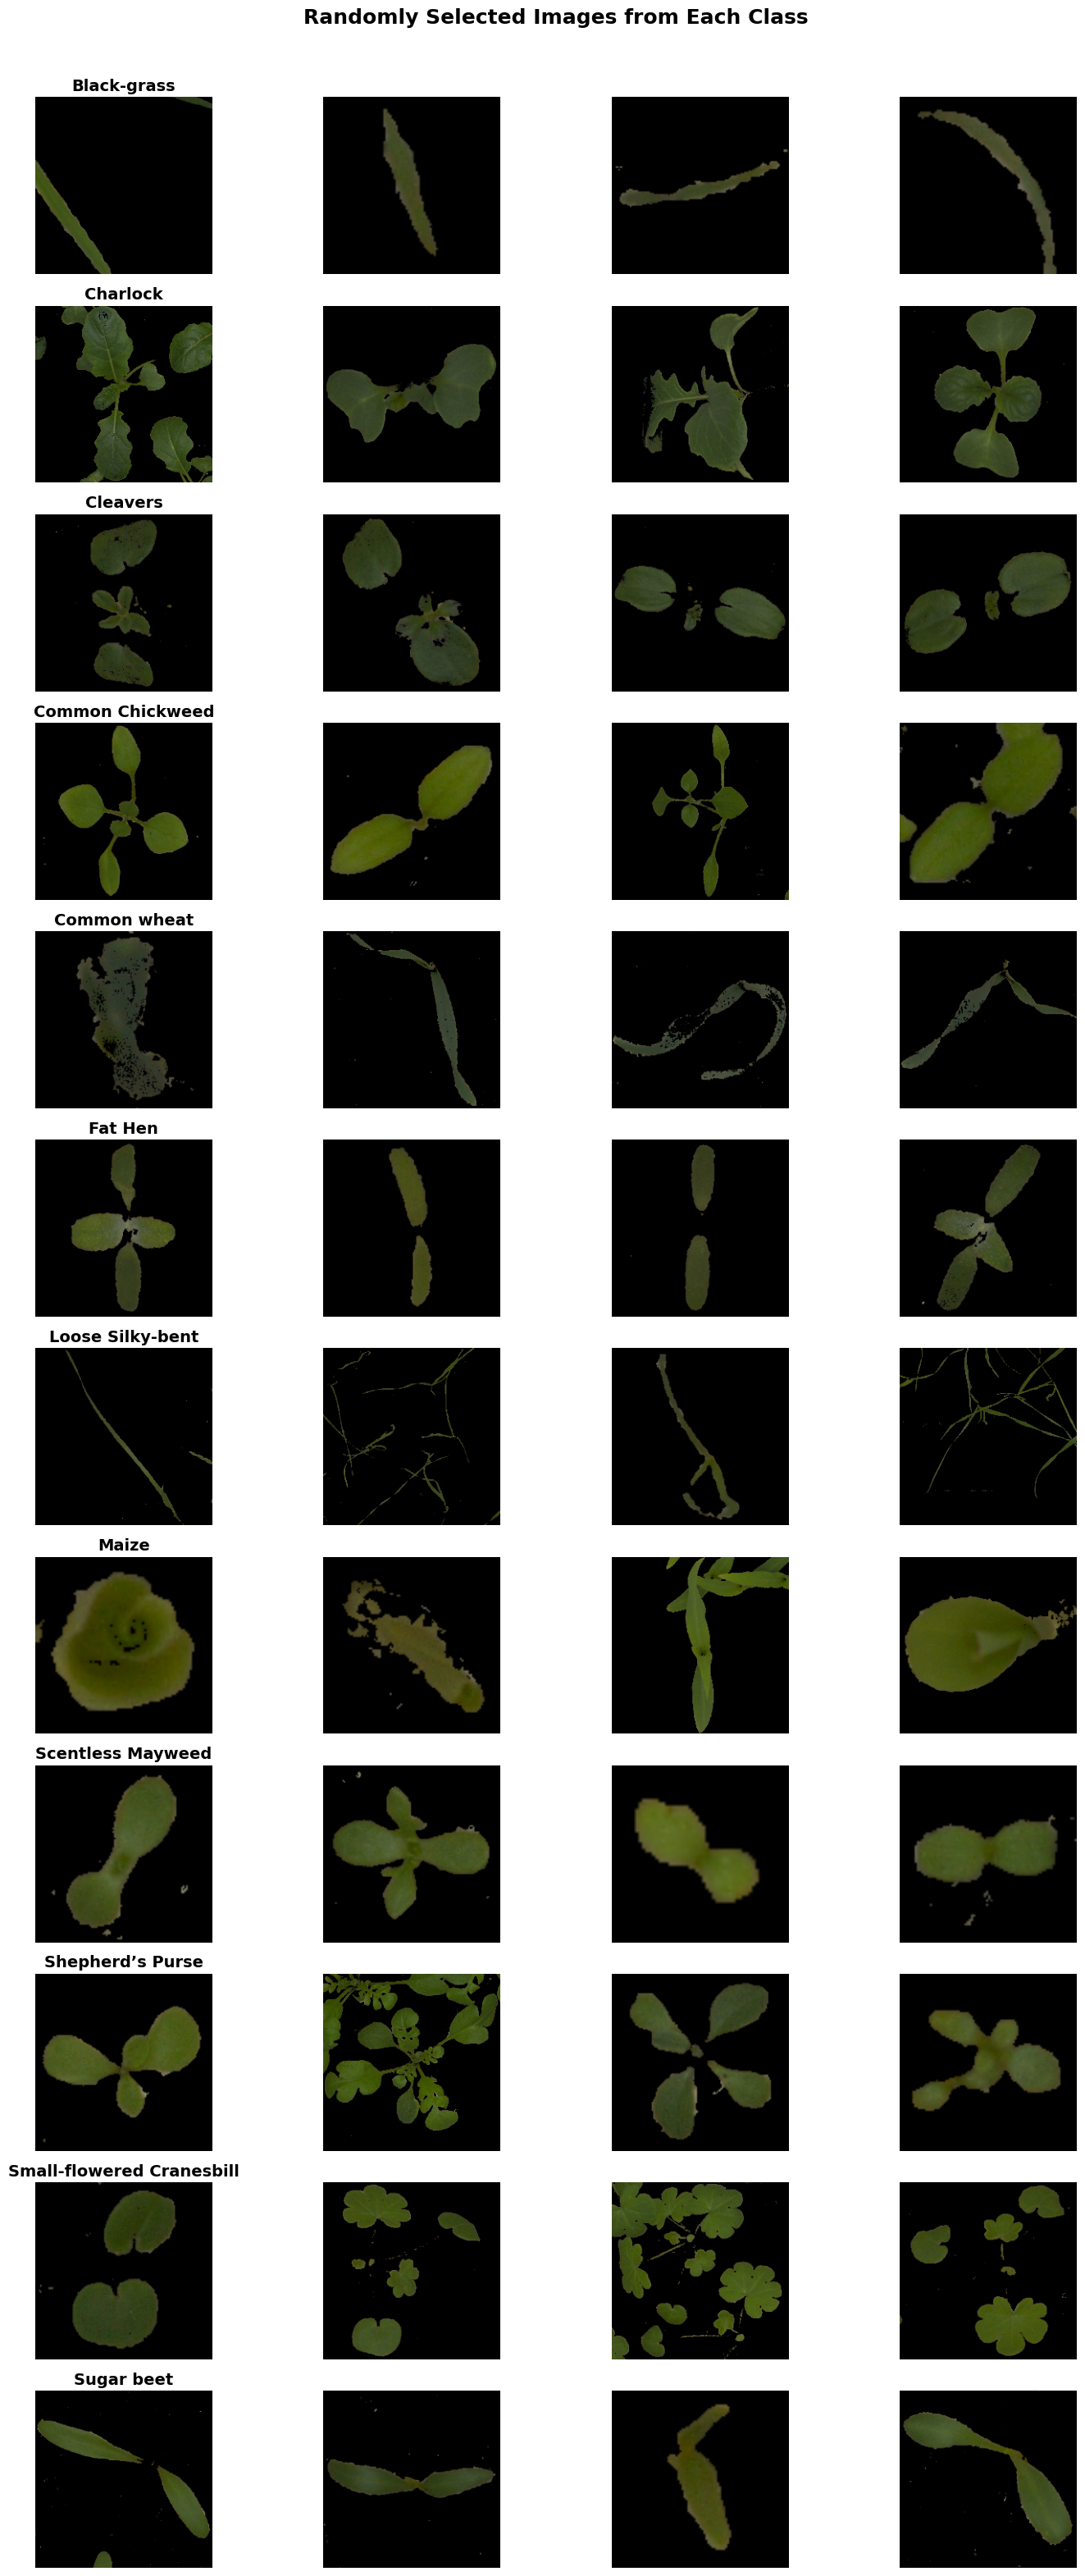

In [48]:
import matplotlib.pyplot as plt
import random


num_images_per_class = 4


fig_width = 15
fig_height = num_images_per_class * 8

plt.figure(figsize=(fig_width, fig_height))

# Loop through each class
for i in range(12):
    # Get indices of images in the current class
    class_indices = np.where(encoded_labels == i)[0]
    
    # Randomly select images from the current class
    selected_indices = random.sample(list(class_indices), num_images_per_class)
    
    # Loop through selected indices and display images
    for j, idx in enumerate(selected_indices, 1):
        plt.subplot(12, num_images_per_class, i * num_images_per_class + j)
        plt.imshow(data[idx])
        plt.axis("off")
        if j == 1:
            plt.title(label_encoder.classes_[i], weight='bold', fontsize=14)


plt.suptitle("Randomly Selected Images from Each Class", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])  

plt.show()


In [49]:
# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/validation"


In [51]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


In [52]:
# Flow training images in batches using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True, save_to_dir=train_dir)

# Flow validation images in batches using ImageDataGenerator
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False, save_to_dir=val_dir)

In [53]:
# Load the pre-trained model MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)


model4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [54]:
history = model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
139/139 [==============================] - 43s 283ms/step - loss: 0.7036 - accuracy: 0.7630 - val_loss: 0.3611 - val_accuracy: 0.8691
Epoch 2/10
139/139 [==============================] - 39s 282ms/step - loss: 0.3180 - accuracy: 0.8838 - val_loss: 0.3962 - val_accuracy: 0.8610
Epoch 3/10
139/139 [==============================] - 39s 282ms/step - loss: 0.2269 - accuracy: 0.9151 - val_loss: 0.2915 - val_accuracy: 0.8899
Epoch 4/10
139/139 [==============================] - 39s 281ms/step - loss: 0.1759 - accuracy: 0.9366 - val_loss: 0.3015 - val_accuracy: 0.8854
Epoch 5/10
139/139 [==============================] - 39s 280ms/step - loss: 0.1413 - accuracy: 0.9463 - val_loss: 0.2665 - val_accuracy: 0.9034
Epoch 6/10
139/139 [==============================] - 39s 281ms/step - loss: 0.1047 - accuracy: 0.9621 - val_loss: 0.3210 - val_accuracy: 0.8998
Epoch 7/10
139/139 [==============================] - 39s 279ms/step - loss: 0.1043 - accuracy: 0.9607 - val_loss: 0.2970 - val_ac

In [55]:
# Evaluate the model on the test set
val_loss, val_accuracy = model4.evaluate(val_generator)

print(f"val Loss: {val_loss}")
print(f"val Accuracy: {val_accuracy}")

35/35 [==============================] - 8s 222ms/step - loss: 0.2665 - accuracy: 0.9034
val Loss: 0.26652762293815613
val Accuracy: 0.9034296274185181
